# Misc dataset

In [1]:
B = 10
f = 0.7
Tb = 1000
kb = 0.2
lb = 5
Tt = 10000
kt = 0.4
lt = 10
s = 0.016
std_dev_multiplier = 1
D_red = 10
Tt_red = 10000
kt_red = 0.4
lt_red = 10
s_red = 0.5

In [2]:
from model.graph_mcmc import Graph_MCMC

In [3]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 22})

In [4]:
import numpy as np


class Graph_Custom (Graph_MCMC):

    def get_feature_names(self):
        feature_name_map = self.G.graph_properties["feat_names"]
        names = []

        for i in range(0, len(feature_name_map)):
            name = feature_name_map[i]
            name = name.replace(";", "-")
            name = name.replace("anonymized feature ", "")
            names.append(name)
        
        return names


    def generate_feature_matrix(self):
        feat_map = self.G.vertex_properties["feat"]
        feat_names = self.get_feature_names()

        vertices = self.G.get_vertices()
        
        N = len(vertices)
        D = len(feat_names)
        X = np.empty((N, D))

        for vertex_index, vertex_id in enumerate(vertices):
            boolean_vector = feat_map[vertex_id]
            for prop_index in range(0, D):
                X[vertex_index, prop_index] = boolean_vector[prop_index]
        
        return X

In [5]:
graph = Graph_Custom()
graph.read_from_ns("ego_social/facebook_1912")

In [6]:
graph.list_props()

name            (graph)   (type: string, val: ego_social (facebook_1912))
description     (graph)   (type: string, val: Ego networks associated with a
                                              set of accounts of three social
                                              media platforms (Facebook,
                                              Google+, and Twitter). Datasets
                                              include node features (profile
                                              metadata), circles, and ego
                                              networks, and were crawled from
                                              public sources in 2012)
citation        (graph)   (type: string, val: ['J. McAuley and J. Leskovec.
                                              "Learning to Discover Social
                                              Circles in Ego Networks." NIPS
                                              (2012). arxiv:1210.8182,
                      

In [7]:
graph.print_info()
graph.partition(B_min=B, B_max=B)

Graph with N=747 nodes, E=30025 edges and D=480 vertex features for training
Performing inference...
Current bracket: (10, 10, 10) (50255.28734165908, 50255.28734165908, 50255.28734165908)
Current bracket: (10, 10, 10) (50255.28734165908, 50255.28734165908, 50255.28734165908)
Bisect at B = 10 with S = 50255.28734165908
Best result: B = 10, S = 50255.28734165908
Done


<VertexPropertyMap object with value type 'int32_t', for Graph 0x7f1ba5145070, at 0x7f1ba09fdcd0>

In [8]:
av_dl = graph.mcmc(num_iter=Tb, burn_in=kb, thinning=lb)

100%|██████████| 1000/1000 [00:03<00:00, 264.46it/s]


In [9]:
#graph.draw(output="fb-graph.png")
graph.draw(output="fb-graph.png")

Drawing soft partition


Drawing block adjacency matrix $e_{rs}$


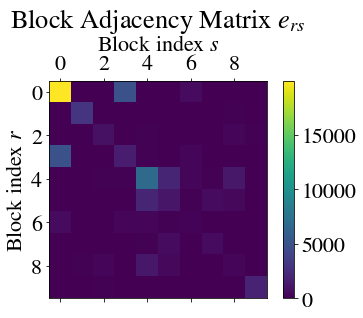

In [10]:
graph.plot_matrix()

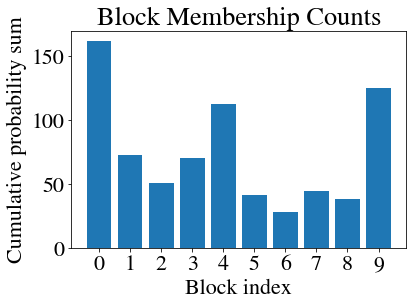

In [11]:
graph.plot_posterior_props()

## Train classifier

In [12]:
from inference.softmax import SoftmaxNeuralNet
import numpy as np

In [13]:
X = graph.generate_feature_matrix()
Y = graph.generate_posterior()

D = X.shape[1]

N = X.shape[0]
assert N == Y.shape[0]



In [14]:
from utils.subsampling import random_index_arr

train_indices, test_indices = random_index_arr(N, fraction=f)
X_train, Y_train = X[train_indices, :], Y[train_indices, :]
X_test, Y_test = X[test_indices, :], Y[test_indices, :]

In [15]:
classifier = SoftmaxNeuralNet(layers_size=[D, B])
classifier.perform_mala(X_train, Y_train, step_scaling=s, num_iter=Tt, verbose=True)

100%|██████████| 10000/10000 [02:38<00:00, 62.95it/s]Sample accept ratio: 84.56%
Train. set accuracy: 56.13026819923371%



(0.8456, 0.5613026819923371)

## Interpret results

### Thinning

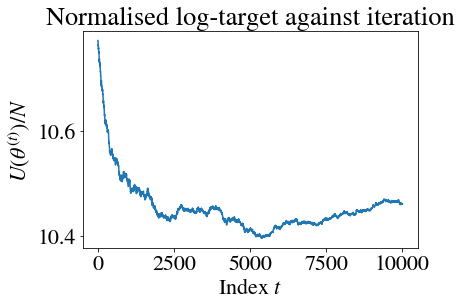

10.454002100330275

In [16]:
classifier.plot_U()

In [17]:
classifier.thin_samples(burn_in=kt, thin_factor=lt)

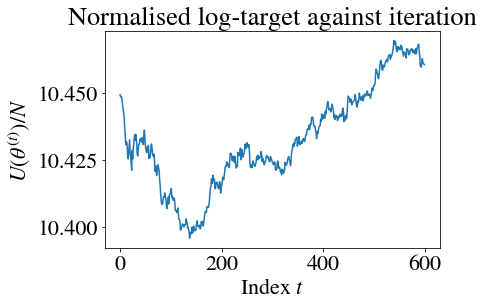

10.432642276046934


In [18]:
u_mean = classifier.plot_U()
print(u_mean)

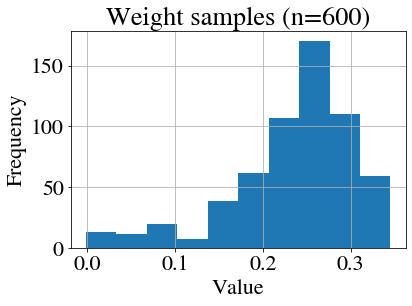

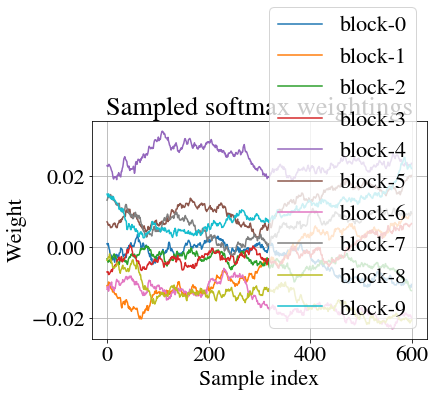

In [19]:
classifier.plot_sample_histogram()
classifier.plot_sample_history()

### Performance

In [20]:
training_loss = classifier.average_loss_per_point(X_train, Y_train, include_prior=False)
test_loss = classifier.average_loss_per_point(X_test, Y_test, include_prior=False)

print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))


Training loss: 1.4801181971042574, Test loss: 1.6164012759933069


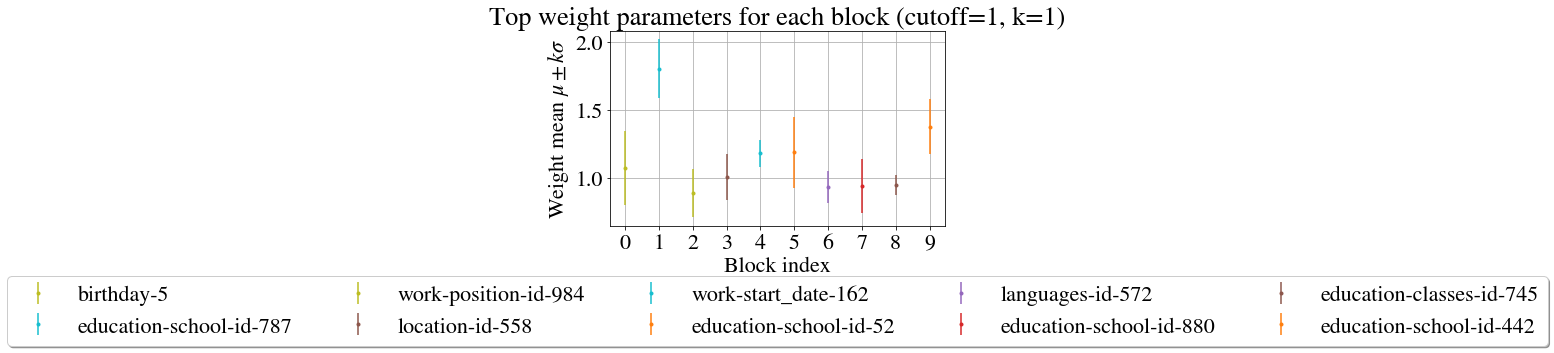

In [21]:
names = list(graph.get_feature_names())
classifier.plot_block_principal_dims(names, cutoff=1, legend=True)

Max cutoff: 0.9272338006862872
Discarded 471 features


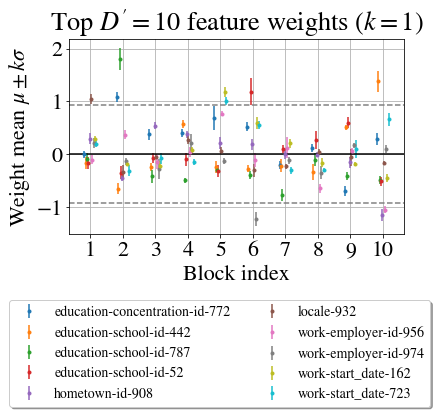

In [22]:
matplotlib.rcParams.update({'font.size': 22})
matplotlib.pyplot.rc('legend',fontsize=14)
names = list(graph.get_feature_names())
kept_features = classifier.plot_sampled_weights(names, std_dev_multiplier=std_dev_multiplier, legend=True, D_reduced=D_red, color_order=False, ncol=2)

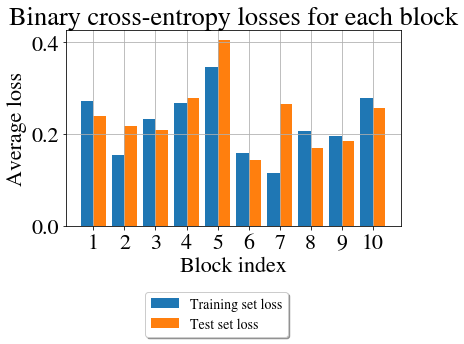

In [23]:
classifier.plot_losses_per_class(X_train, Y_train, X_test, Y_test)

In [24]:
reduced_X_train, reduced_X_test = X_train[:, kept_features], X_test[:, kept_features]

reduced_D = reduced_X_train.shape[1]

# nwo train new classifier
reduced_classifier = SoftmaxNeuralNet(layers_size=[reduced_D, B])
reduced_classifier.perform_mala(reduced_X_train, Y_train, step_scaling=s_red, num_iter=Tt_red, verbose=True)

100%|██████████| 10000/10000 [00:09<00:00, 1012.21it/s]Sample accept ratio: 82.33%
Train. set accuracy: 43.86973180076628%



(0.8233, 0.4386973180076628)

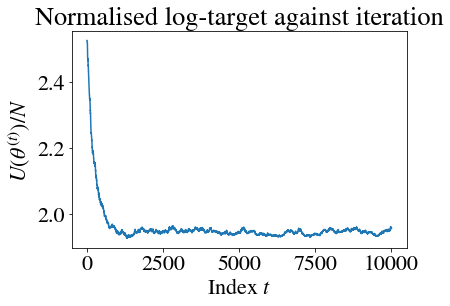

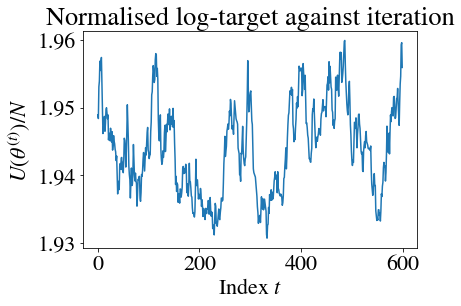

1.9440808502479292

In [25]:
reduced_classifier.plot_U()
reduced_classifier.thin_samples(burn_in=kt_red, thin_factor=lt_red)
reduced_classifier.plot_U()

In [26]:
reduced_training_loss = reduced_classifier.average_loss_per_point(reduced_X_train, Y_train, include_prior=False)
reduced_test_loss = reduced_classifier.average_loss_per_point(reduced_X_test, Y_test, include_prior=False)

print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

REDUCED CLASSIFIER -- Training loss: 1.6779334536319643, Test loss: 1.738676735670271


In [27]:
print("Average description length per entity: {}".format(av_dl))
print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))
print("D': {}".format(len(kept_features)))
print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

Average description length per entity: 1.6291355628129374
Training loss: 1.4801181971042574, Test loss: 1.6164012759933069
D': 10
REDUCED CLASSIFIER -- Training loss: 1.6779334536319643, Test loss: 1.738676735670271


In [28]:
results = [av_dl, training_loss, test_loss, len(kept_features), reduced_training_loss, reduced_test_loss]
print(results)

[1.6291355628129374, 1.4801181971042574, 1.6164012759933069, 10, 1.6779334536319643, 1.738676735670271]
